In [1]:
# !pip install torch
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/train.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/08fdd4217a1bc231.jpg  
  inflating: __MACOSX/train/._08fdd4217a1bc231.jpg  
  inflating: train/1ce86af3a48ad68b.jpg  
  inflating: __MACOSX/train/._1ce86af3a48ad68b.jpg  
  inflating: train/1282246e4db471b9.jpg  
  inflating: __MACOSX/train/._1282246e4db471b9.jpg  
  inflating: train/0be6edbe75b6895a.jpg  
  inflating: __MACOSX/train/._0be6edbe75b6895a.jpg  
  inflating: train/0108d9c833113277.jpg  
  inflating: __MACOSX/train/._0108d9c833113277.jpg  
  inflating: train/15c5b86c84c70357.jpg  
  inflating: __MACOSX/train/._15c5b86c84c70357.jpg  
  inflating: train/1aab573525820cb4.jpg  
  inflating: __MACOSX/train/._1aab573525820cb4.jpg  
  inflating: train/0a05495d288a8a0b.jpg  
  inflating: __MACOSX/train/._0a05495d288a8a0b.jpg  
  inflating: train/0a483f22996da2ba.jpg  
  inflating: __MACOSX/train/._0a483f22996da2ba.jpg  
  inflating: train/0ca35cd0e0d7a56c.jpg  
  inflating: __MACOSX/train/._0ca35cd0e0d7a56c.jpg  

In [3]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/test.zip


Archive:  /content/drive/MyDrive/cs444-final-project/project/data/small_data/test.zip
   creating: test/
  inflating: __MACOSX/._test         
  inflating: test/05cd51a8acabe799.jpg  
  inflating: __MACOSX/test/._05cd51a8acabe799.jpg  
  inflating: test/081fcd5bc43c74ce.jpg  
  inflating: __MACOSX/test/._081fcd5bc43c74ce.jpg  
  inflating: test/20f51dbec422b415.jpg  
  inflating: __MACOSX/test/._20f51dbec422b415.jpg  
  inflating: test/18d86ead28f1801f.jpg  
  inflating: __MACOSX/test/._18d86ead28f1801f.jpg  
  inflating: test/0408807f220acfd3.jpg  
  inflating: __MACOSX/test/._0408807f220acfd3.jpg  
  inflating: test/07b1ef4cb759334b.jpg  
  inflating: __MACOSX/test/._07b1ef4cb759334b.jpg  
  inflating: test/02e03209141f945c.jpg  
  inflating: __MACOSX/test/._02e03209141f945c.jpg  
  inflating: test/087b94c079d87fec.jpg  
  inflating: __MACOSX/test/._087b94c079d87fec.jpg  
  inflating: test/1e02edbbbe52b984.jpg  
  inflating: __MACOSX/test/._1e02edbbbe52b984.jpg  
  inflating: test/1d

In [4]:
from torchvision import datasets, models, transforms
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LandmarkImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, id_path_mapping="", is_pt=False):
        """
        Args:
            annotations_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            file_extension (string, optional): Extension of the image files in the directory.
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.id_to_label = {str(row[0]): row[3] for row in self.img_labels.values}
        self.transform = transform
        self.id_path_mapping = pd.read_csv(id_path_mapping)
        self.length = len(self.id_path_mapping)
        self.is_pt = is_pt


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Retrieve the image ID and path from the mapping
        image_id = self.id_path_mapping.iloc[idx]['id']
        image_path = self.id_path_mapping.iloc[idx]['path']

        label = self.id_to_label[str(image_id)]

        if self.is_pt:
            tensor = torch.load(image_path)
            if self.transform:
                tensor = self.transform(tensor)
            return tensor, label
        else:
            # Load the image
            image = Image.open(image_path)
            # Apply transform if any
            if self.transform:
                image = self.transform(image)
            return image, label


# Define transformations for the training data
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_pt = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
# train_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/train_img_id_to_path_mapping.csv"
train_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/train_img_id_to_path_mapping_drive.csv" # "/content/drive/MyDrive/cs444-final-project/project/data/small_data/train_pt_id_to_path_mapping.csv"
# Create an instance of the dataset
train_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=train_img_id_to_path_mapping,
    # is_pt=True
    is_pt=False
)

# Define the DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2)



In [5]:
len(train_dataset)

6731

# Model Initialization

In [6]:
from torchvision import models
import torch

def initialize_model(num_classes):
    # Load a pretrained ResNet-18 model
    model = models.resnet18(pretrained=True)
    # Modify the final layer to match the number of classes
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, num_classes)
    return model

# Determine the number of unique classes
num_classes = len(set(train_dataset.id_to_label.values()))

# num_classes=2000
print(f"number of classes {num_classes}")
model = initialize_model(num_classes=num_classes)



number of classes 25


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


# Model Finetuning

In [7]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

def train_model(model, train_loader, loss_fn, optimizer, device, epochs=10):
    model.to(device)
    train_losses = []
    train_accuracies = []
    best_train_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Wrap the training loop with tqdm for a progress bar
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update the progress bar with current loss and accuracy
            progress_bar.set_postfix(loss=f'{running_loss / total_samples:.4f}', acc=f'{(correct_predictions.double() / total_samples * 100):.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)


        # Save the best model if the training loss has improved
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/cs444-final-project/project/models/baselines/saved_models/resnet-18_best_model.pth')
            print(f'Saved best model with Train Loss: {epoch_loss}')

    return train_losses, train_accuracies



In [8]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    plt.figure(figsize=(10, 5))

    # Create the first axis for the training loss
    ax1 = plt.gca()  # Get current axis
    line1, = ax1.plot(train_losses, label='Training Loss', color='red', marker='o')
    ax1.set_xlabel('Epochs')  # Common x-axis label
    ax1.set_ylabel('Loss', color='red')  # Set y-axis label for loss
    ax1.tick_params(axis='y', labelcolor='red')  # Set the color of y-axis ticks to red

    # Create a second y-axis for the training accuracy using twinx()
    ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
    line2, = ax2.plot(train_accuracies, label='Training Accuracy', color='blue', marker='x')
    ax2.set_ylabel('Accuracy', color='blue')  # Set y-axis label for accuracy
    ax2.tick_params(axis='y', labelcolor='blue')  # Set the color of y-axis ticks to blue

    # Title and grid
    plt.title('Training Loss and Accuracy')
    ax1.grid(True)

    # Create legends and position them appropriately
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='center right')  # Position the legend in the center right

    plt.show()


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  print("CUDA USED")
else:
  print("CPU USED")

CUDA USED


In [10]:
# Initialize the model, optimizer, and loss function
model = initialize_model(num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Move the model to the appropriate device
model.to(device)

# Train the model
train_losses, train_accuracies = train_model(model, train_loader, loss_fn, optimizer, device, epochs=30)

Epoch 1/30:   0%|          | 0/421 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Saved best model with Train Loss: 1.9741592677641935


Saved best model with Train Loss: 1.5727024091111226


Saved best model with Train Loss: 1.4299704365945485


Saved best model with Train Loss: 1.2777812761252396


Saved best model with Train Loss: 1.202424080383183


Saved best model with Train Loss: 1.125567401106737


Saved best model with Train Loss: 1.0277014962992588


Saved best model with Train Loss: 1.0002745416130419


Saved best model with Train Loss: 0.9268134781236886


Saved best model with Train Loss: 0.8508347407372717


Saved best model with Train Loss: 0.7893143404195541


Saved best model with Train Loss: 0.753574025071715


Saved best model with Train Loss: 0.6705369615215021


Saved best model with Train Loss: 0.5953715198679944


Saved best model with Train Loss: 0.5569813620130976


Saved best model with Train Loss: 0.502889638470216


Saved best model with Train Loss: 0.44493808626526893


Saved best model with Train Loss: 0.40513308880731214


Saved best model with Train Loss: 0.3388336661256266


Saved best model with Train Loss: 0.3107210710742057


Saved best model with Train Loss: 0.25736688330079344


Saved best model with Train Loss: 0.23751373134217182


Saved best model with Train Loss: 0.2112410853245249


Saved best model with Train Loss: 0.20342785040040515


Saved best model with Train Loss: 0.1973566164289139


Saved best model with Train Loss: 0.17707168202484447


Saved best model with Train Loss: 0.16268158076726996


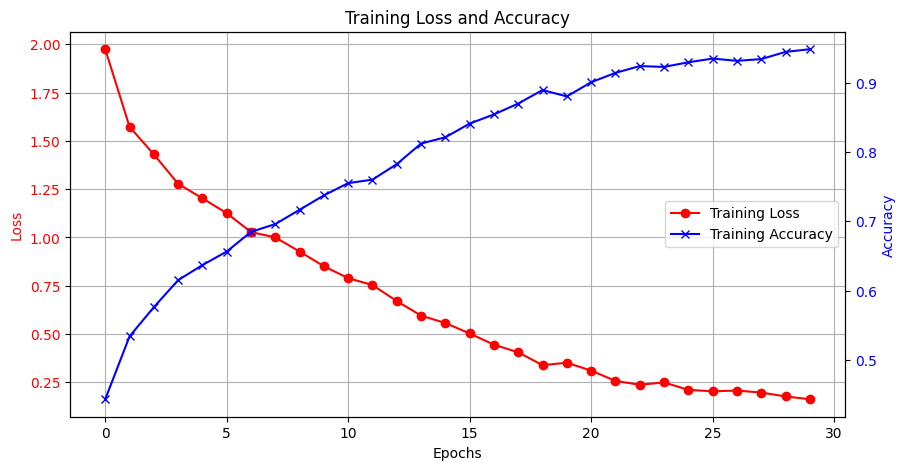

maximum accuracy achieved with 94.8596% at epoch 30


In [21]:
# Plot losses
import numpy as np
acc = [acc.item() for acc in train_accuracies]
plot_metrics(train_losses, acc)
print(f"maximum accuracy achieved with {round(max(acc), 6) * 100}% at epoch {np.argmax(acc) + 1}")

# Test and Eavluation

In [22]:
def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0  # Track total samples processed

    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Evaluating", leave=False)
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update the progress bar with average loss and accuracy
            average_loss = running_loss / total_samples
            average_accuracy = correct_predictions.double() / total_samples
            progress_bar.set_postfix({'avg_loss': f'{average_loss:.4f}', 'avg_acc': f'{average_accuracy:.2f}'})

    total_loss = running_loss / len(dataloader)
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    print(f'Validation Loss: {total_loss}, Accuracy: {accuracy}')
    return total_loss, accuracy  # Optionally return metrics for further analysis


In [25]:
# Define transformations for the training data
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
test_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/test_img_id_to_path_mapping_drive.csv"
# Create an instance of the dataset
test_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=test_img_id_to_path_mapping
)

# Define the DataLoader
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=2)

model.to(device)
model_path = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/saved_models/resnet-18_best_model.pth'
model.load_state_dict(torch.load(model_path))

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, device)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                                                                                            

Validation Loss: 1.7962557056634372, Accuracy: 0.6938775510204082
Test Loss: 1.7962557056634372, Test Accuracy: 0.6938775510204082


In [ ]:
# plot_metrics(test_loss, test_accuracy)